# EDGAR Temporal profiles

This tutorial demonstrates how to use the auxiliary temporal profiles from edgar.

The function we will use is :py:func:`emiproc.inventories.edgar.temporal.read_edgar_auxilary_profiles`.


## Loading EDGAR

Similarly to the EDGAR tutorial, we first load the inventory.


In [ ]:
from pathlib import Path
from emiproc.inventories.edgar import download_edgar_files
from emiproc.inventories.edgar import EDGARv8

year = 2022

local_dir = Path("./edgar") / str(year)
local_dir.mkdir(exist_ok=True, parents=True)

# download_edgar_files(local_dir, year=year, substances=["CH4", "CO2", "CO2bio"])
inv = EDGARv8(
    local_dir / "EDGAR_*.nc",
    year=year,
    # Use short names, as this is how they are defined in the axilary table
    use_short_category_names=True,
)
inv

Inventory(EDGARv8)

## Download the auxilliary data

Now you have to make a manual step to download the auxilliary data from EDGAR website.

You can find the `auxilliary_tables.rar` file at https://edgar.jrc.ec.europa.eu/dataset_temp_profile 

Download it and extract its files in a local directory.
You should have 4 `.csv` files.

## Read the profiles

In [3]:
from emiproc.inventories.edgar.temporal import read_edgar_auxilary_profiles

path_to_auxiliary_filesdir = Path("/home/coli/Data/emiproc/aux_edgar/")
profiles, indices = read_edgar_auxilary_profiles(
    auxiliary_filesdir=path_to_auxiliary_filesdir,
    inventory=inv,
)

### What is in the profiles ?

There are two components to emiproc profiles: 
* the `profiles` themselves, which are objects of different temporal profile classes. 
* the `indices`, a xarray dataset that tells for each sector/pollutant/gridcell/... which profile to use.

In [4]:
profiles

CompositeProfiles(76 profiles from ['HourOfWeekPerMonthProfile', 'WeeklyProfile'])

We have 2 types of profiles:

Weekly profiles that specify for each weekday how much of emissions are there.

HourOfWeekPerMonth: which sounds scary, but it means that for each hour of a week
there is a profile value and also for each month this value is different.

In [5]:
indices

<xarray.DataArray (country: 234, category: 24)> Size: 45kB
array([[40, 63, 52, ...,  3, 24, 24],
       [10, 39, 34, ...,  4, 16, 16],
       [40, 63, 52, ...,  3, 24, 24],
       ...,
       [40, 63, 52, ...,  3, 24, 24],
       [40, 63, 52, ...,  3, 24, 24],
       [40, 63, 52, ...,  3, 24, 24]], shape=(234, 24))
Coordinates:
  * category  (category) object 192B 'ENE' 'CHE' ... 'TNR_Aviation_CRS'
  * country   (country) object 2kB 'ABW' 'AFG' 'AGO' 'AIA' ... 'PSE' 'ATA' 'ATF'

In the indices, we have a 2 dimensional array with country and category as dimensions.

This means that each country and emission category can have a different temporal profile.

### Set the profiles to the inventory

Now that we have loaded the profiles, we can set them to the inventory.

In [8]:
inv.set_profiles(
    profiles=profiles,
    indexes=indices,
)
inv.t_profiles_indexes

<xarray.DataArray (country: 234, category: 24)> Size: 45kB
array([[40, 63, 52, ...,  3, 24, 24],
       [10, 39, 34, ...,  4, 16, 16],
       [40, 63, 52, ...,  3, 24, 24],
       ...,
       [40, 63, 52, ...,  3, 24, 24],
       [40, 63, 52, ...,  3, 24, 24],
       [40, 63, 52, ...,  3, 24, 24]], shape=(234, 24))
Coordinates:
  * category  (category) object 192B 'ENE' 'CHE' ... 'TNR_Aviation_CRS'
  * country   (country) object 2kB 'ABW' 'AFG' 'AGO' 'AIA' ... 'PSE' 'ATA' 'ATF'

### Grouping Categories

When groupping categories, the profiles are automatically groupped. 

This is done by a weighted average, so that categories with more emissions have more weight in the average during groupping.

In [13]:
from emiproc.inventories.utils import group_categories


grouped = group_categories(
    inv,
    categories_group={
        "agriculture": [
            # Agriculture
            "ENF",  # Enteric fermentation
            "MNM",  # Manure management
            "AWB",  # Agricultural waste burning
            "AGS",  # Agricultural soils
            "N2O",  # Indirect N2O emissions from agriculture
            "IDE",  # Indirect emissions from NOx and NH3
        ],
        "industry": [
            "ENE",  # Power Industry
            "REF_TRF",  # Refineries
            "IND",  # Combustion for manufacturing
            "RCO",  # Energy for buildings
            "PRO_FFF",  # Fuel exploitation
            "NMM",  # Non-metallic minerals production
            "CHE",  # Chemical processes
            "IRO",  # Iron and steel production
            "NFE",  # Non-ferrous metals production
            "NEU",  # Non-energy use of fuels
            "PRU_SOL",  # Solvents and products use
        ],
        "waste": [
            "SWD_LDF",  # Solid waste landfills
            "SWD_INC",  # Solid waste incineration
            "WWT",  # Waste water handling
        ],
        "transportation": [
            "TNR_Aviation_CDS",
            "TNR_Aviation_CRS",
            "TNR_Aviation_LTO",
            "TNR_Aviation_SPS",
            "TNR_Other",
            "TNR_Ship",
            "TRO",  # Road transport
        ],
    },
    ignore_missing=True,
)
grouped.t_profiles_indexes.coords


Coordinates:
  * category  (category) object 32B 'agriculture' ... 'transportation'
  * country   (country) object 2kB 'ABW' 'AFG' 'AGO' 'AIA' ... 'PSE' 'ATA' 'ATF'

Now the profiles are given for the grouped categories.

## Remapping

The profiles are defined per countries, but the inventory is given on a grid. 
If we want to export the inventory with the profiles, we can 
remap the profiles onto the grid of the inventory.

First we will remap edgar to a coarser grid to speed up the process.

In [16]:
from emiproc.grids import RegularGrid
from emiproc.regrid import remap_inventory


grid = RegularGrid(xmin=-12, xmax=48, ymin=32, ymax=72, nx=60, ny=40)
remapped = remap_inventory(grouped, grid)

/home/coli/Documents/Projects/emiproc/emiproc/regrid.py:251: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_weights.geometry_inter.area / gdf_weights.geometry.area


In [18]:
from emiproc.inventories.utils import country_to_cells


celled = country_to_cells(remapped)
celled.t_profiles_indexes.coords

89.6%

Coordinates:
  * category  (category) object 32B 'agriculture' ... 'transportation'
  * cell      (cell) int64 19kB 0 1 2 3 4 5 6 ... 2394 2395 2396 2397 2398 2399

Now we have a profile for each cell of the inventory

## Generate time series

In [26]:
from emiproc.exports.hourly import get_temporally_scaled_array
import pandas as pd

da = get_temporally_scaled_array(
    inv=celled,
    time_range=pd.date_range("2022-01-01", "2022-01-14", freq="h"), 
    sum_over_cells=False,
)
da.coords

Coordinates:
  * substance  (substance) <U6 72B 'CH4' 'CO2' 'CO2bio'
  * category   (category) object 32B 'agriculture' 'waste' ... 'transportation'
  * cell       (cell) int64 19kB 0 1 2 3 4 5 6 ... 2394 2395 2396 2397 2398 2399
  * time       (time) datetime64[ns] 3kB 2022-01-01 ... 2022-01-14

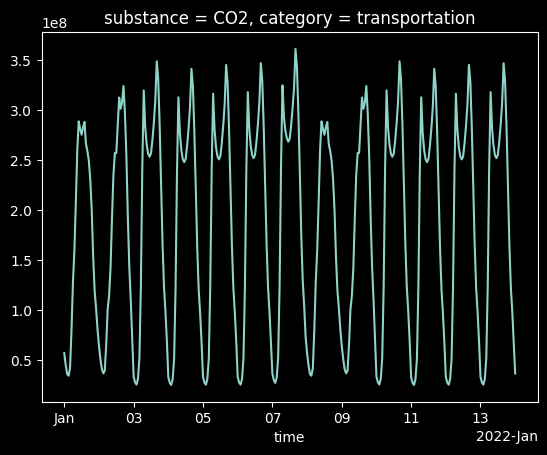

In [29]:
# Output is kg/year/cell, so we need to convert the units to kg/h/cell
from emiproc.profiles.temporal.constants import N_HOUR_YEAR

da /=  N_HOUR_YEAR

da.sel(substance="CO2", category="transportation").sum(dim="cell").plot(x='time')

There we can see our temporal profile on the domain.

## Conclusion

In this tutorial, we learned how to read EDGAR temporal profiles and combine them to the inventory.

If you have any questions, please refer to our [support page](https://emiproc.readthedocs.io/en/master/support.html#support).